In [ ]:
import os
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, RGCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem

from src.utils.constants import HOME_DIR, DATA_DIR

In [9]:
data_path = DATA_DIR + 'clean_data.csv'
data = pd.read_csv(data_path)

x = data['Canonical_QSARr']
y = data['LD50_mgkg'].to_numpy()
y = np.log(y)
y = list(y)

print('length of x:', len(x))
print('sample of x:', x[0])
print('====================')

print('length of y:', len(y))
print('sample of y:', y[0])

length of x: 5306
sample of x: [O-][N+](=O)C1C=CC(Cl)=CC=1
length of y: 5306
sample of y: 6.131226489483141


In [10]:
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

# Load the pretrained ChemBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = RobertaForSequenceClassification.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", num_labels=1)  # For regression

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels, tokenizer, max_length=128):
        self.smiles_list = smiles_list
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        label = self.labels[idx]

        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Return input IDs, attention mask, and label
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float),
        }

# Example usage:
smiles_list = x  # Replace with your dataset's SMILES strings
labels = y  # Replace with your dataset's LD50 values

# train test val split
from sklearn.model_selection import train_test_split

dataset = SMILESDataset(smiles_list, labels, tokenizer)

test_size = int(len(dataset) * 0.1)
val_size = int(len(dataset) * 0.1)
train_size = len(dataset) - test_size - val_size

train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
from transformers import AdamW
import torch.nn as nn

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

# Training loop
# Draw a graph of training loss, validation loss
epochs = 5

train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()

    total_train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze()  # Output shape: [batch_size]

        # Compute loss
        loss = loss_fn(predictions, labels)
        total_train_loss += loss.item()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
    
    train_losses.append(total_train_loss / len(train_loader))

    # Validation
    model.eval()

    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = outputs.logits.squeeze()

            # Compute loss
            loss = loss_fn(predictions, labels)
            total_val_loss += loss.item()

    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

  0%|          | 0/133 [00:00<?, ?it/s]

100%|██████████| 133/133 [03:55<00:00,  1.77s/it]


Epoch 1, Train Loss: 2.0791, Val Loss: 2.2402


100%|██████████| 133/133 [03:44<00:00,  1.69s/it]


Epoch 2, Train Loss: 1.7283, Val Loss: 2.4404


100%|██████████| 133/133 [03:38<00:00,  1.64s/it]


Epoch 3, Train Loss: 1.5105, Val Loss: 2.2716


100%|██████████| 133/133 [03:45<00:00,  1.70s/it]


Epoch 4, Train Loss: 1.3288, Val Loss: 2.4080


100%|██████████| 133/133 [03:38<00:00,  1.65s/it]


Epoch 5, Train Loss: 1.1399, Val Loss: 2.2770


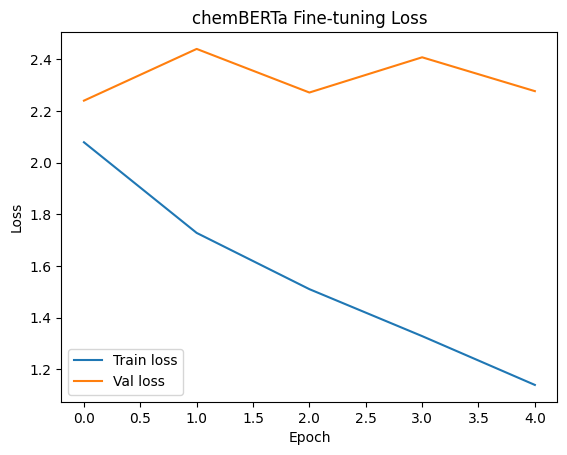

In [20]:
# Draw a graph of training loss, validation loss
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("chemBERTa Fine-tuning Loss")
plt.legend()
plt.show()